In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import time
params = {
    'axes.labelsize': 16,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'axes.titlesize': 18,
    'font.family': 'serif',
    'text.usetex': False
   }
plt.rcParams.update(params)
import P4J

## Generating a simple synthetic light curve
We create an irregulary sampled time series using a harmonic model composed of three sine waves with an specified Signal to Noise Ratio SNR)

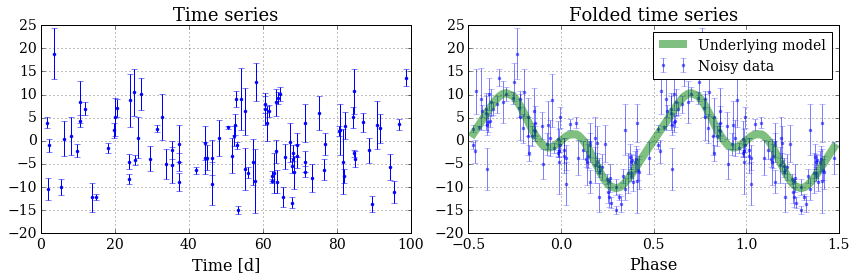

In [2]:
f0 = 2.0
t = P4J.irregular_sampling(T=100.0, N=100)
y = P4J.trigonometric_model(t, f0, A=np.array([1.0, 0.5, -0.25]))
y, y_noisy, dy = P4J.contaminate_time_series(t, y, SNR=2.0, out_p=0.0)

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.errorbar(t, y_noisy, dy, fmt='.')
ax.set_xlabel('Time [d]')
ax.set_title('Time series')
plt.grid()
ax = fig.add_subplot(1, 2, 2)
phase = np.mod(t, 1/f0)*f0
index = np.argsort(phase)
ax.errorbar(np.concatenate([np.sort(phase)-0.5, np.sort(phase)+0.5]), 
            np.concatenate([y_noisy[index], y_noisy[index]]), 
            np.concatenate([dy[index], dy[index]]), fmt='.', alpha=0.5, label='Noisy data')
ax.plot(np.concatenate([np.sort(phase)-0.5, np.sort(phase)+0.5]), 
        np.concatenate([y[index], y[index]]), 
        linewidth=8, alpha=0.5, label='Underlying model')
plt.legend()
ax.set_xlabel('Phase')
ax.set_title('Folded time series')
plt.grid()
plt.tight_layout()

## Recovering the underlying model from the data

Let's try to recover the clean underlying model from the noisy data, assumming that we now the fundamental frequency (f0). In this demo we compare the Weighted Maximum Correntropy Criterion (WMCC) with the broadly used Weighted Least Squares (WLS) criterion.

Normalized Mean Squared Error (NMSE) of the fit:
WLS: 0.362753
WMCC: 0.039968


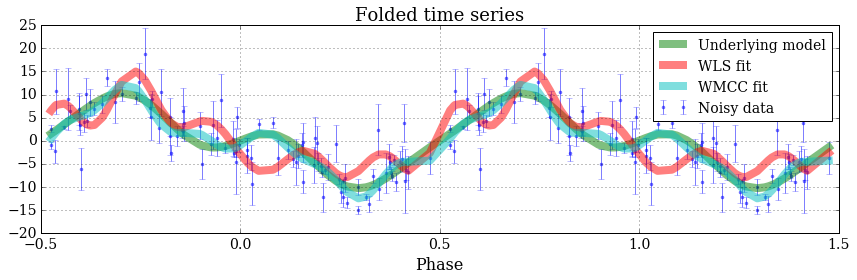

In [13]:
def NMSE(y_estimated, y_target):
    return np.sum(np.power(y_target - y_estimated, 2.0))/np.sum(np.power(y_target - np.mean(y_target), 2.0))

Phi = P4J.harmonic_dictionary(t, f0, M=6)

beta_WLS = P4J.find_beta_WLS(y_noisy, Phi, dy)
model_WLS = np.dot(Phi, beta_WLS)

beta_WMCC, cost,_ = P4J.find_beta_WMCC(y_noisy, Phi, dy)
model_WMCC = np.dot(Phi, beta_WMCC)
print("Normalized Mean Squared Error (NMSE) of the fit:")
print("WLS: %f" % (NMSE(y, model_WLS)))
print("WMCC: %f" % (NMSE(y, model_WMCC)))

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)
phase = np.mod(t, 1/f0)*f0
index = np.argsort(phase)
ax.errorbar(np.concatenate([np.sort(phase)-0.5, np.sort(phase)+0.5]), 
            np.concatenate([y_noisy[index], y_noisy[index]]), 
            np.concatenate([dy[index], dy[index]]), fmt='.', alpha=0.5, label='Noisy data')
ax.plot(np.concatenate([np.sort(phase)-0.5, np.sort(phase)+0.5]), 
        np.concatenate([y[index], y[index]]), 
        linewidth=8, alpha=0.5, label='Underlying model')
ax.plot(np.concatenate([np.sort(phase)-0.5, np.sort(phase)+0.5]), 
        np.concatenate([model_WLS[index], model_WLS[index]]), 
        linewidth=8, alpha=0.5, label='WLS fit')
ax.plot(np.concatenate([np.sort(phase)-0.5, np.sort(phase)+0.5]), 
        np.concatenate([model_WMCC[index], model_WMCC[index]]), 
        linewidth=8, alpha=0.5, label='WMCC fit')
plt.legend()
ax.set_xlabel('Phase')
ax.set_title('Folded time series')
plt.grid()
plt.tight_layout()

## Finding the best frequency using the WMCC

Now let's assumme that we do not know the best frequency for this data. To find it, we perform a fit over a set of frequencies and find the one that maximizes the WMCC

Maximum of the periodogram found at 2.000172


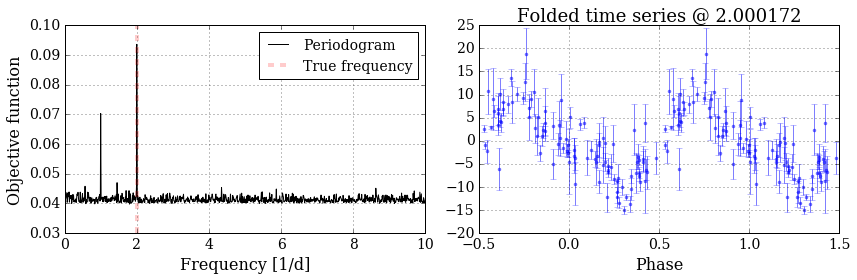

In [10]:
my_per = P4J.periodogram(M=3)
my_per.fit(t, y_noisy, dy)
freq, obj = my_per.grid_search(fmin=0.0, fmax=10.0, fres_coarse=1.0, fres_fine=0.1)
fbest = freq[np.argmax(obj)]
print("Maximum of the periodogram found at %f" %(fbest))

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(freq, obj, 'k-',  linewidth=1, label='Periodogram')
ymin, ymax = ax.get_ylim()
ax.plot([f0, f0], [ymin, ymax], 'r--', linewidth=4, alpha=0.2, label='True frequency')
ax.set_ylim([ymin, ymax])
ax.set_xlabel('Frequency [1/d]')
ax.set_ylabel('Objective function')
plt.legend()
plt.grid()
ax = fig.add_subplot(1, 2, 2)
phase = np.mod(t, 1/fbest)*fbest
index = np.argsort(phase)
ax.errorbar(np.concatenate([np.sort(phase)-0.5, np.sort(phase)+0.5]), 
            np.concatenate([y_noisy[index], y_noisy[index]]), 
            np.concatenate([dy[index], dy[index]]), fmt='.', alpha=0.5)
ax.set_xlabel('Phase')
ax.set_title('Folded time series @ %f' % (fbest))
plt.grid()
plt.tight_layout()